# #TODO - dokończ

### Treść zadania

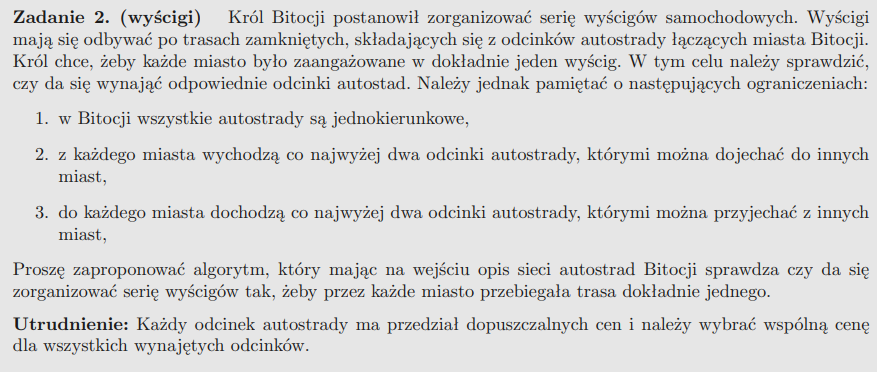

### Omówienie algorytmu

W tym przypadku mamy taką sytuację, że do danego miasta mogą dochodzić maksymalnie dwie krawędzie, ale tylko jedna z nich może być fragmentem trasy, na której odbywa się wyścig, ponieważ dane miasto może uczestniczyć tylko w jednym wyścigu w danym czasie. Ponieważ również chcemy sprawdzić, czy możliwe jest, aby wszystkie miasta uczestniczyły w jakimś wyścigu, musimy sprawdzić tak naprawdę, czy dla każdego miasta przynajmniej jedna z krawędzi wchodzących (jeżeli są dwie) lub dokładnie jedna (jeżeli jest jedna) znajduje się na trasie danego wyścigu. Jeżeli z danego miasta wychodzi jedna krawędź, to ta krawędź również musi uczestniczyć w wyściugu, a jeżeli są dwie, to dokładnie jedna z tych dwóch musi uczestniczyć w wyścigu. Problem da się rozwiązać, przekształacając nasze zagadnienie na formułę w postaci CNF i sprawdzając, czy jest ona spełnialna. Mamy wówczas możliwe poniższe przypadki, które odpowiednio przekształcimy na pewien fragment docelowej formuły:

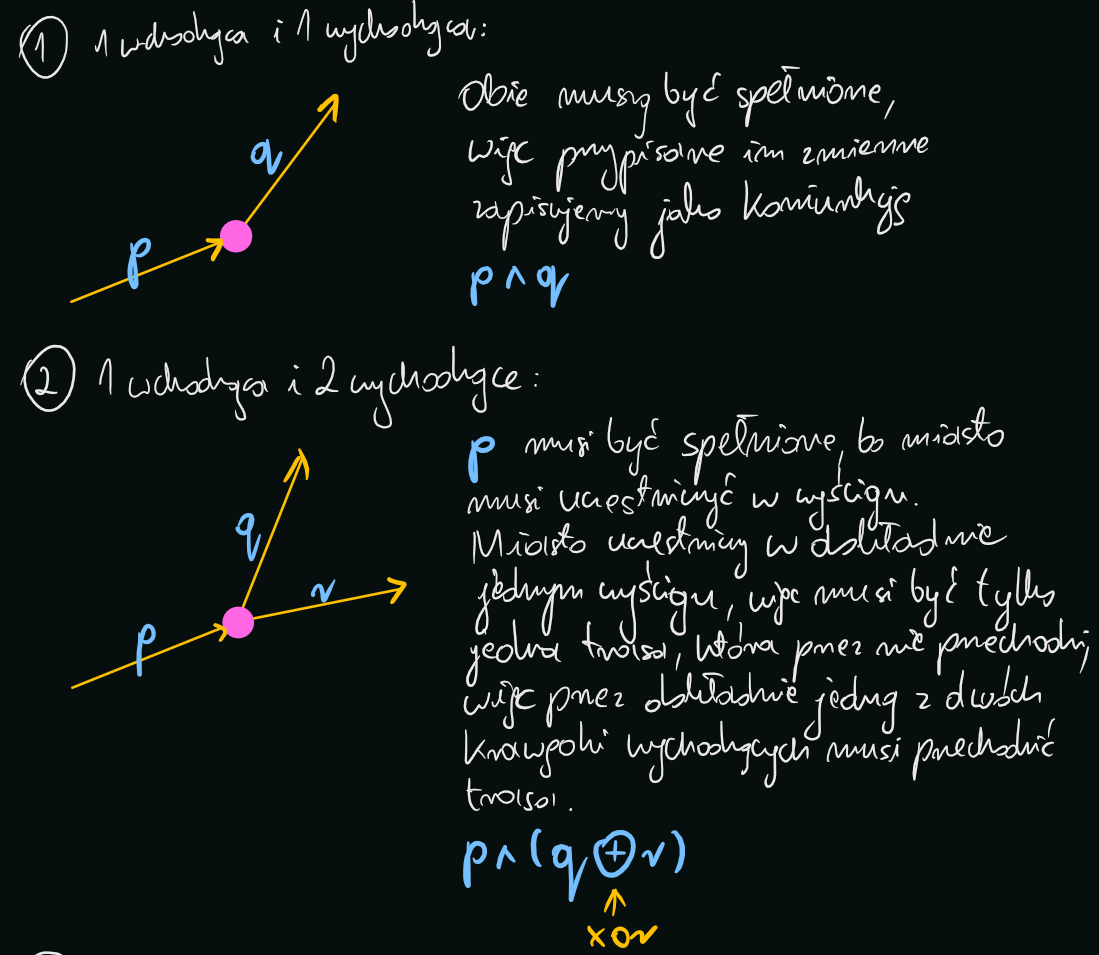
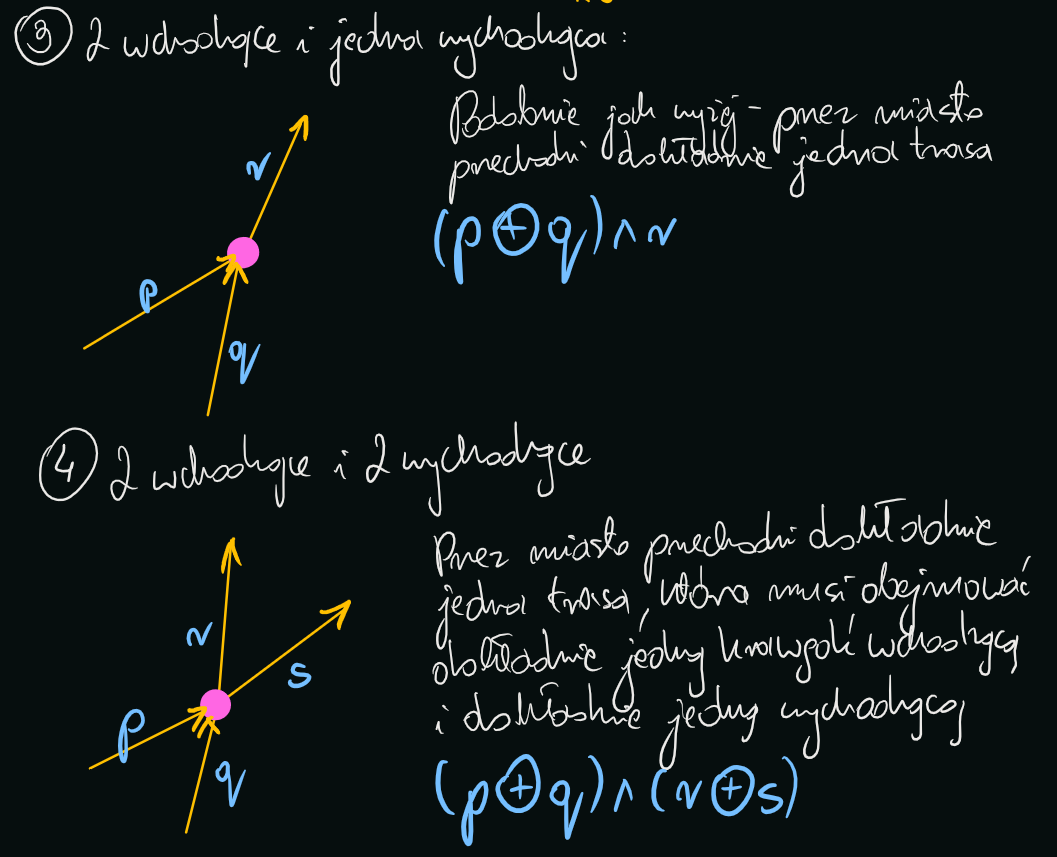

W taki sposób musimy utworzyć część formuły dla każdego z wierzchołków i dołączyć ją, przy pomocy operatora koniunkcji, do pozostałej części formuły. 
<br><br>
Następnie konieczne jest przekształenie każdej pary literałów, połączonych operatorem $ \oplus $, w taki sposób, aby otrzymać formułę w postaci CNF, zgodnie z poniższą regułą: 
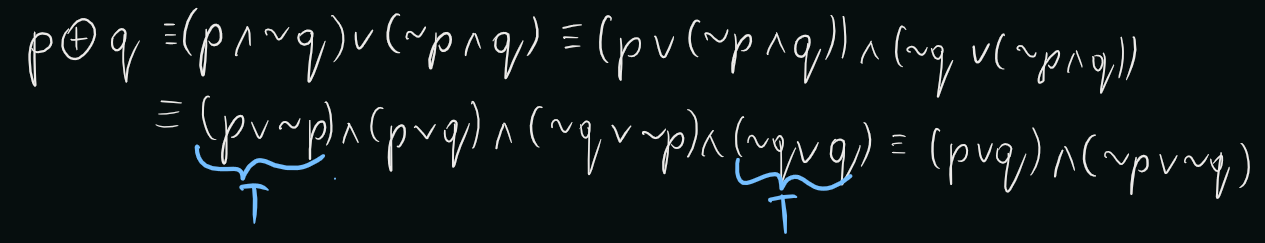

W kolejnym kroku, mając formułę w postaci CNF, postępujemy tak, jak zostało to omówione w zadaniu 1. (standardowym) z tego zestawu (LINK: https://tinyurl.com/3pjs458k), czyli zamieniamy wszystkie alternatywy, jakie się pojawiły, po wykonaniu powyższego przekształcenia, na implikacje w taki sposób:
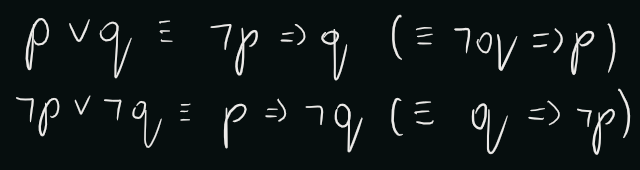

Teraz możemy już przejść do zbudowania grafu w taki sposób, że wierzchołkami są wszystkie literały, a więc, jeżeli jakiejś krawędzi przyporządkowaliśmy literał $ p $, to w grafie będziemy mieli wierzchołki $ p $ oraz $ \neg p $. Między wierzchołkami dodajemy krawędź skierowaną w taki sposób, w jaki wyglądają otrzymane wyżej implikacje, a więc, jeżeli mieliśmy: <br>
$ p \oplus q \equiv (p \vee q) \wedge (\neg p \vee \neg q) $ <br>
to biorąc pod uwagę powyższe zdjęcie, które przedstawia zamianę alternatyw na implikacje, otrzymujemy następujące 4 implikacje, z których każda musi zostać spełniona (dwie z nich są tak naprawdę przekształconymi dwiema pozostałymi): <br>
$ (\neg p \Rightarrow q) $, $ (\neg q \Rightarrow p) $, $ (p \Rightarrow \neg q) $, $ (q \Rightarrow \neg p) $
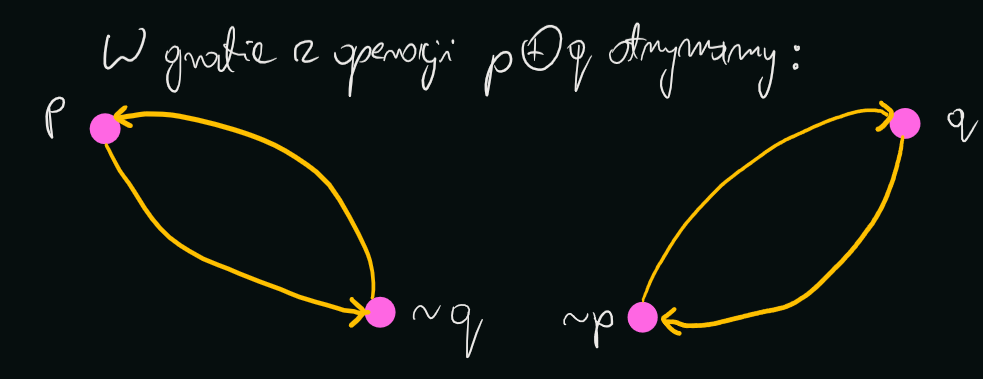

# #TODO - dokończ implementację

### Implementacja

In [44]:
def get_transposed_graph(G: 'graph represented using adjacency lists'):
    n = len(G)
    G2 = [[] for _ in range(n)]
    
    for u in range(n):
        for v in G[u]:
            G2[v].append(u)
            
    return G2


def create_CNF_graph(G: 'input graph', G2: 'transposed input graph'):
    n = len(G)
    # Store numbers assigned to edges
    P = [[None] * n for _ in range(n)]
    # G3 will be implications graph
    G3 = []
    idx = 0
    
    def add_vertex(u, v):
        nonlocal idx
        G3.append([])
        G3.append([])
        # Index of a forumla vertex and its negation
        P[u][v] = (idx, idx + 1)
        idx += 2
        
    def add_xor(x, y):
        p, _p = x
        q, _q = y
        G3[_p].append(q)
        G3[_q].append(p)
        G3[p].append(_q)
        G3[q].append(_p)
    
    for u in range(n):
        # Case 1 (one ingoing and one outgoing edge)
        if len(G[u]) == len(G2[u]) == 1:
            # Add two vertices to the resulting graph (only if hadn't added before)
            # (only vertices because there is no implication)
            x = G[u][0]; y = G2[u][0]
            if not P[u][x]: add_vertex(u, x)
            if not P[y][u]: add_vertex(y, u)
        # Case 2 (one ingoing and two outgoing edges)
        elif len(G[u]) == 2 and len(G2[u]) == 1:
            x = G[u][0]; y = G[u][1]; z = G2[u][0]
            if not P[z][u]: add_vertex(z, u)
            if not P[u][x]: add_vertex(u, x)
            if not P[u][y]: add_vertex(u, y)
            add_xor(P[u][x], P[u][y])
        # Case 3 (two ingoing and one outgoing edge)
        elif len(G[u]) == 1 and len(G2[u]) == 2:
            x = G[u][0]; y = G2[u][0]; z = G2[u][1]
            if not P[y][u]: add_vertex(y, u)
            if not P[z][u]: add_vertex(z, u)
            if not P[u][x]: add_vertex(u, x)
            add_xor(P[y][u], P[z][u])
        # Case 4 (two ingoing and two outgoing edges)
        elif len(G[u]) == len(G2[u]) == 2:
            x = G[u][0]; y = G[u][1]; z = G2[u][0]; t = G2[u][1]
            if not P[z][u]: add_vertex(z, u)
            if not P[t][u]: add_vertex(t, u)
            if not P[u][x]: add_vertex(u, x)
            if not P[u][y]: add_vertex(u, y)
            add_xor(P[z][u], P[t][u])
            add_xor(P[u][x], P[u][y])
            
    print(*P, sep='\n')
            
    return G3


def get_process_times(G: 'graph represented using adjacency lists'):
    n = len(G)
    times = [0] * n
    visited = [False] * n
    time = 0
    
    def dfs(u):
        visited[u] = True
        for v in G[u]:
            if not visited[v]:
                dfs(v)
        nonlocal time
        time += 1
        times[u] = time
        
    for u in range(n):
        if not visited[u]:
            dfs(u)
            
    return times


def find_coherent_components(G: 'graph represented using adjacency lists'):
    n = len(G)
    # Get processing time of each vertex
    times = get_process_times(G)
    # Create a transposed graph
    G = get_transposed_graph(G)
    # Get order of vertices in which DFS will be started from such vertices
    order = sorted(range(n), key=lambda i: times[i], reverse=True)
    # Create an array in which a result will be stored (each number will refer
    # to the other coherent component of a graph)
    result = [-1] * n  # This array will also be used to check if a vertex was visited
    num = 0
    
    def dfs(u):
        result[u] = num
        for v in G[u]:
            if result[v] < 0:
                dfs(v)
        
    # Start dfs from vertices of the highest processing time
    for i in range(n):
        u = order[i]
        if result[u] < 0:
            dfs(u)
            num += 1
            
    return result, num


def coherent_components_graph(G, components, n):
    G2 = [[] for _ in range(n)]
    
    for u in range(len(G)):
        for v in G[u]:
            if components[u] != components[v]:
                G2[components[u]].append(components[v])
                
    return G2
    

def can_organize_races(G: 'streets graph'):
    G2 = get_transposed_graph(G)
    G3 = create_CNF_graph(G, G2)
    components, m = find_coherent_components(G3)
    G4 = coherent_components_graph(G3, components, m)
    print(*G3, sep='\n')
    print()
    print(components)
    print()
    print(*G4, sep='\n')

###### Kilka testów

##### Pomocnicze

In [45]:
def directed_graph_list(E: 'array of edges'):
    # Find a number of vertices
    n = 0
    for e in E:
        n = max(n, e[0], e[1])
    n += 1
    # Create a graph
    G = [[] for _ in range(n)]
    for e in E:
        G[e[0]].append(e[1])
    return G

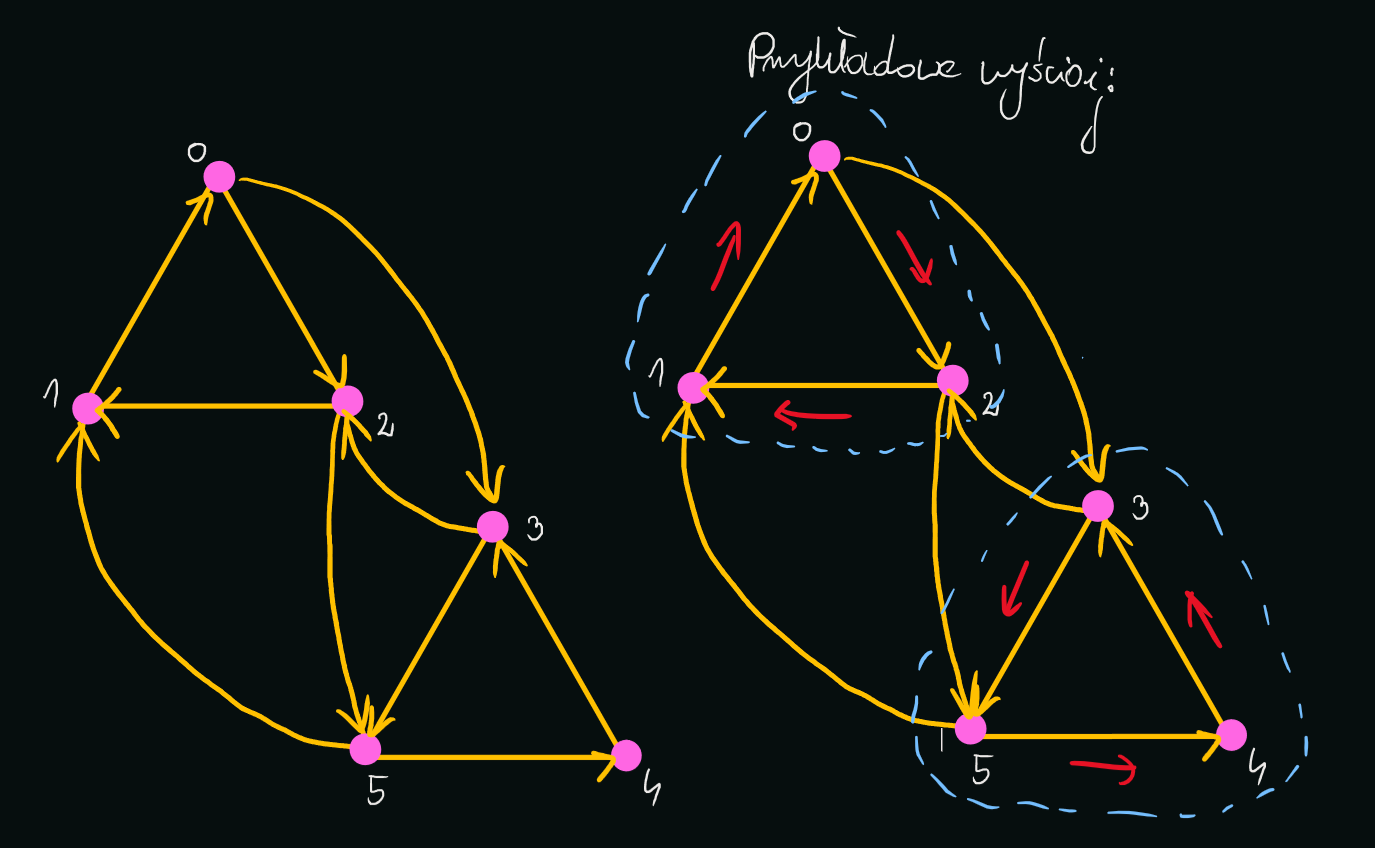

In [48]:
E = [(0, 2), (0, 3), (1, 0), (2, 1), (2, 5), (3, 2), (3, 5), (4, 3), (5, 4), (5, 6), (6, 1)]
G = directed_graph_list(E)

In [49]:
print(can_organize_races(G), sep='\n')

[None, None, (2, 3), (4, 5), None, None, None]
[(0, 1), None, None, None, None, None, None]
[None, (6, 7), None, None, None, (12, 13), None]
[None, None, (10, 11), None, None, (16, 17), None]
[None, None, None, (14, 15), None, None, None]
[None, None, None, None, (18, 19), None, (20, 21)]
[None, (8, 9), None, None, None, None, None]
[]
[]
[5, 11]
[4, 10]
[3, 15]
[2, 14]
[9, 13]
[8, 12]
[7]
[6]
[3, 17]
[2, 16]
[7, 17]
[6, 16]
[5]
[4]
[11, 13]
[10, 12]
[21]
[20]
[19]
[18]

[5, 4, 3, 2, 2, 3, 3, 2, 2, 3, 2, 3, 2, 3, 3, 2, 3, 2, 1, 0, 0, 1]

[]
[]
[]
[]
[]
[]
None
